In [226]:
import mne 
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(1,1))
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import itertools
from sklearn.svm import SVC  


In [198]:
def arrayFiles(path):
    folderContent = os.listdir(path)
    fifFiles = []
    for i in folderContent :
        fifFiles.append(path + "/" + i)
    
    return fifFiles

In [199]:
path = '/Volumes/flash64/EpochedEEG'
allFifFiles = arrayFiles(path)

In [200]:
epoch = mne.read_epochs(allFifFiles[0],preload=True)

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [201]:
new_stim_code_event_ids = {
     
    "b-f2-wrd":1,
    "b-f1-wrd":2,
    "b-tg-wrd":3,

    "b-f2-spk":4,
    "b-f1-spk":5,
    "b-tg-spk":6,

    "b-f2-pic":7,
    "b-f1-pic":8,
    "b-tg-pic":9,

    "b-f2-snd":10,
    "b-f1-snd":11,
    "b-tg-snd":12,

    "f-f2-wrd":13,
    "f-f1-wrd":14,
    "f-tg-wrd":15,

    "f-f2-spk":16,
    "f-f1-spk":17,
    "f-tg-spk":18,

    "f-f2-pic":19,
    "f-f1-pic":20,
    "f-tg-pic":21,

    "f-f2-snd":22,
    "f-f1-snd":23,
    "f-tg-snd":24
}

In [202]:
#update stim code events using above dict
def update_stim_code(epoch):
    keys_to_delete = [x for x in epoch.event_id if 'stim' in x]
    for key in keys_to_delete:
        if 'stim' in key:
            del epoch.event_id[key]
            
    for key in new_stim_code_event_ids:
        epoch.event_id[key] = new_stim_code_event_ids[key]
    
    return epoch

In [203]:
epochWnewStim = update_stim_code(epoch)
epochWnewStim .events.shape

(5424, 3)

In [204]:
#epochWnewStim .event_id

In [205]:
events = epochWnewStim.events[:,-1]
event_ids = epochWnewStim.event_id

In [206]:
stim_combinations = {
    (5,6,4): "AALL",
    (17,18,16) :"AALL",
    
    (11,6,10):"AALN",
    (23,18,22):"AALN",
    
    (5,12,4) :"AANL",
    (17,24,16):"AANL",
    
    (11,12,10) : "AANN",
    (23,24,22): "AANN",
    
    (2,6,1):"AVLL",
    (14,18,13):"AVLL",
    
    (8,12,7):"AVNN",
    (20,24,19):"AVNN",
    
    (5,3,4) :"VALL",
    (17,15,16):"VALL",
    
    (11,9,10) :"VANN",
    (23,21,22):"VANN",
    
    (2,3,1) :"VVLL",
    (14,15,13):"VVLL",
    
    (8,3,7):"VVLN",
    (20,15,19):"VVLN",
    
    (2,9,1) :"VVNL",
    (14,21,13):"VVNL",
    
    (8,9,7) :"VVNN",
    (20,21,19):"VVNN",
    
    (14,21,4):"whatever"
    
    
    
}

In [208]:
#filter events for visual and audio
events = epochWnewStim.events
events_new = []
temp = []
combo = []


for event in events:
    if event[-1] == 31:
        combo = []
        for trialEpochs in temp:
            if trialEpochs[-1] >=1 and trialEpochs[-1]<=24:
                combo.append(trialEpochs[-1])
        if len(combo) == 3: 
            combo_tuple = (combo[0],combo[1],combo[2]) 
            if stim_combinations[combo_tuple] == "VVLN" or stim_combinations[combo_tuple] == "VVLL" :
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 100
            elif stim_combinations[combo_tuple] == "AALN" or stim_combinations[combo_tuple] == "AALL":
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 200       
            combo_tuple = []
                
        
        for p in temp:
            if p[-1] == 100 or p[-1] == 200:
                events_new.append(p)
#             if p[-1] >=1 and p[-1] <=24:
#                 events_new.append(p)
        temp = []
        temp.append(event)
    else:
        temp.append(event)
events_new

[array([2593,    0,  100]),
 array([2718,    0,  100]),
 array([2847,    0,  100]),
 array([3682,    0,  100]),
 array([3807,    0,  100]),
 array([3936,    0,  100]),
 array([4500,    0,  100]),
 array([4625,    0,  100]),
 array([4754,    0,  100]),
 array([5043,    0,  100]),
 array([5168,    0,  100]),
 array([5297,    0,  100]),
 array([5581,    0,  100]),
 array([5706,    0,  100]),
 array([5835,    0,  100]),
 array([6120,    0,  100]),
 array([6244,    0,  100]),
 array([6374,    0,  100]),
 array([6658,    0,  100]),
 array([6778,    0,  100]),
 array([6912,    0,  100]),
 array([7200,    0,  100]),
 array([7321,    0,  100]),
 array([7454,    0,  100]),
 array([7739,    0,  100]),
 array([7864,    0,  100]),
 array([7993,    0,  100]),
 array([8281,    0,  100]),
 array([8406,    0,  100]),
 array([8535,    0,  100]),
 array([8820,    0,  100]),
 array([8944,    0,  100]),
 array([9074,    0,  100]),
 array([9358,    0,  100]),
 array([9483,    0,  100]),
 array([9612,    0, 

In [231]:
#Select data with events 100 and 200
test = epochWnewStim[(epochWnewStim.events[:,-1]==100) | (epochWnewStim.events[:,-1]==200)]

In [210]:
#classify using LDA
dataXX = test.get_data()
eventsYY = test.events[:,-1]

clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LDA())

#cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True)
preds = np.empty(len(eventsYY))
scoresss = []
for train,test in cv.split(dataXX,eventsYY):
    clf.fit(dataXX[train],eventsYY[train])
    preds[test] = clf.predict(dataXX[test])
    scoresss.append(clf.score(dataXX[test],eventsYY[test]))

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

In [211]:
print("mean classification score", np.mean(scoresss))

mean classification score 0.6716666666666667


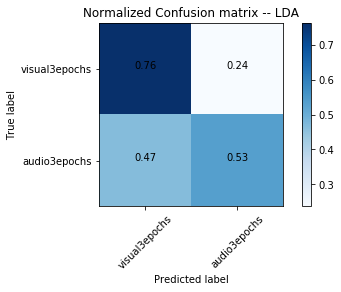

In [212]:
target_names = [ 'visual3epochs', 'audio3epochs']
# Normalized confusion matrix
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout



cm = confusion_matrix(eventsYY,preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix -- LDA')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

fmt = '.2f'
for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j],fmt),
                 horizontalalignment="center",
                 color="black")
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [229]:
#init PCA and fit to data
#28 is the optimal components to use
pca = UnsupervisedSpatialFilter(PCA(n_components=28), average=False)
pca_data = pca.fit_transform(dataXX)

In [232]:
#Classify using PCA data
eventsYY = test.events[:,-1]

clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LDA())

#cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True)
preds = np.empty(len(eventsYY))
scoresss = []
for train,test in cv.split(pca_data,eventsYY):
    clf.fit(pca_data[train],eventsYY[train])
    preds[test] = clf.predict(pca_data[test])
    scoresss.append(clf.score(pca_data[test],eventsYY[test]))

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

In [233]:
print("mean classification score", np.mean(scoresss))

mean classification score 0.6616666666666667


In [216]:
#classify using Logistic Regression
dataXXx = test.get_data()
eventsYYy = test.events[:,-1]

clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression())

#cross validation
cv2 = StratifiedKFold(n_splits = 10, shuffle=True)
preds2 = np.empty(len(eventsYY))
scorez = []
for train,test in cv2.split(dataXXx,eventsYYy):
    clf.fit(dataXXx[train],eventsYYy[train])
    preds2[test] = clf.predict(dataXXx[test])
    scorez.append(clf.score(dataXXx[test],eventsYYy[test]))

In [217]:
print("mean classification score", np.mean(scorez))

mean classification score 0.6916666666666668


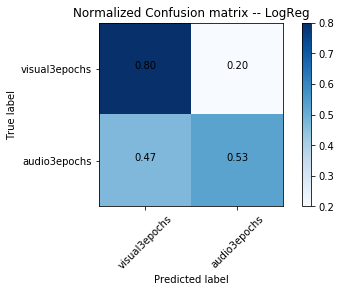

In [219]:
target_names = [ 'visual3epochs', 'audio3epochs']
# Normalized confusion matrix
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout



cm = confusion_matrix(eventsYYy,preds2)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix -- LogReg')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

fmt = '.2f'
for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j],fmt),
                 horizontalalignment="center",
                 color="black")
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [227]:
#classify using SVC
dataXXxx = test.get_data()
eventsYYyy = test.events[:,-1]

clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    SVC())

#cross validation
cv3 = StratifiedKFold(n_splits = 10, shuffle=True)
preds3 = np.empty(len(eventsYYyy))
scorzz = []
for train,test in cv3.split(dataXXxx,eventsYYyy):
    clf.fit(dataXXxx[train],eventsYYyy[train])
    preds3[test] = clf.predict(dataXXxx[test])
    scorzz.append(clf.score(dataXXxx[test],eventsYYyy[test]))

In [228]:
print("mean classification score", np.mean(scorzz))

mean classification score 0.5999999999999999
